In [1]:
# Import Packages
import torch
import torch.nn as nn
import torch.nn.functional as F

## Graph Convolution

In [2]:
class GCNLayer(nn.Module):
    def __init__(self, c_in, c_out):
        super().__init__()
        self.projection = nn.Linear(c_in, c_out)
        
    def forward(self, node_feats, adj_matrix):
        '''
        :param node_feats: Tensor with node features of shape [batch_size, num_nodes, c_in] 
        :param adj_matrix: Batch of adjacency matrices of the graph. If there is an edje from i to j, adj_batrix[b,i,j]=1, else 0. Supports directed edges by non-symmetric matrices. Assumes to already have added the identity connections. shape: [batch_size, num_nodes, num_nodes]
        :return: node_feats
        '''
        '''***implement the GCN Layer'''
        num_neighbors = adj_matrix.sum(dim=2, keepdim=True)
        node_feats = torch.matmul(adj_matrix, node_feats)
        node_feats = node_feats / num_neighbors
        node_feats = self.projection(node_feats)
        return node_feats

In [3]:
node_feats = torch.arange(8, dtype=torch.float32).view(1,4,2)
adj_matrix = torch.Tensor([[[1, 1, 0, 0],
                            [1, 1, 1, 1],
                            [0, 1, 1, 1],
                            [0, 1, 1, 1]]])

print("Node features: \n", node_feats)
print("\nAdjacency matrix: \n", adj_matrix)

Node features: 
 tensor([[[0., 1.],
         [2., 3.],
         [4., 5.],
         [6., 7.]]])

Adjacency matrix: 
 tensor([[[1., 1., 0., 0.],
         [1., 1., 1., 1.],
         [0., 1., 1., 1.],
         [0., 1., 1., 1.]]])


In [4]:
layer = GCNLayer(c_in=2, c_out=2)
layer.projection.weight.data = torch.Tensor([[1., 0.], [0., 1.]])
layer.projection.bias.data = torch.Tensor([0.0, 0.0])

with torch.no_grad():
    out_feats = layer(node_feats, adj_matrix)

print("Adjacency Matrix", adj_matrix)
print("Input Features", node_feats)
print("Output Features", out_feats)

Adjacency Matrix tensor([[[1., 1., 0., 0.],
         [1., 1., 1., 1.],
         [0., 1., 1., 1.],
         [0., 1., 1., 1.]]])
Input Features tensor([[[0., 1.],
         [2., 3.],
         [4., 5.],
         [6., 7.]]])
Output Features tensor([[[1., 2.],
         [3., 4.],
         [4., 5.],
         [4., 5.]]])


## Graph Attention

In [5]:
class GATLayer(nn.Module):
    def __init__(self, c_in, c_out, num_heads=1, concat_heads=True, alpha=0.2):
        """
        Inputs:
            c_in - Dimensionality of input features
            c_out - Dimensionality of output features
            num_heads - Number of heads, i.e. attention mechanisms to apply in parallel. The 
                        output features are equally split up over the heads if concat_heads=True.
            concat_heads - If True, the output of the different heads is concatenated instead of averaged.
            alpha - Negative slope of the LeakyReLU activation.
        """
        super().__init__()
        self.num_heads = num_heads
        self.concat_heads = concat_heads
        if self.concat_heads:
            assert c_out % num_heads == 0, "Number of output features must be a multiple of the count of heads."
            c_out = c_out // num_heads
        
        # Sub-modules and parameters needed in the layer
        self.projection = nn.Linear(c_in, c_out * num_heads)
        self.a = nn.Parameter(torch.Tensor(num_heads, 2 * c_out)) # One per head
        self.leakyrelu = nn.LeakyReLU(alpha)
        
        # Initialization from the original implementation
        nn.init.xavier_uniform_(self.projection.weight.data, gain=1.414)
        nn.init.xavier_uniform_(self.a.data, gain=1.414)
        
    def forward(self, node_feats, adj_matrix, print_attn_probs=False):
        """
        Inputs:
            node_feats: Input features of the node. Shape: [batch_size, c_in]
            adj_matrix: Adjacency matrix including self-connections. Shape: [batch_size, num_nodes, num_nodes]
            print_attn_probs: If True, the attention weights are printed during the forward pass (for debugging purposes)
        """
        batch_size, num_nodes = node_feats.size(0), node_feats.size(1)
        

        node_feats = self.projection(node_feats)
        node_feats = node_feats.view(batch_size, num_nodes, self.num_heads, -1)
        
        # We need to calculate the attention logits for every edge in the adjacency matrix 
        # Doing this on all possible combinations of nodes is very expensive
        # => Create a tensor of [W*h_i||W*h_j] with i and j being the indices of all edges
        edges = adj_matrix.nonzero(as_tuple=False) # Returns indices where the adjacency matrix is not 0 => edges
        node_feats_flat = node_feats.view(batch_size * num_nodes, self.num_heads, -1)
        edge_indices_row = edges[:,0] * num_nodes + edges[:,1]
        edge_indices_col = edges[:,0] * num_nodes + edges[:,2]
        a_input = torch.cat([
            torch.index_select(input=node_feats_flat, index=edge_indices_row, dim=0),
            torch.index_select(input=node_feats_flat, index=edge_indices_col, dim=0)
        ], dim=-1) # Index select returns a tensor with node_feats_flat being indexed at the desired positions along dim=0
        
        # Calculate attention MLP output (independent for each head)
        attn_logits = torch.einsum('bhc,hc->bh', a_input, self.a) 
        attn_logits = self.leakyrelu(attn_logits)
        
        # Map list of attention values back into a matrix
        attn_matrix = attn_logits.new_zeros(adj_matrix.shape+(self.num_heads,)).fill_(-9e15)
        attn_matrix[adj_matrix[...,None].repeat(1,1,1,self.num_heads) == 1] = attn_logits.reshape(-1)
        
        attn_probs = F.softmax(attn_matrix, dim=2)
        if print_attn_probs:
            print("Attention probs\n", attn_probs.permute(0, 3, 1, 2))
        node_feats = torch.einsum('bijh,bjhc->bihc', attn_probs, node_feats)
        
        # If heads should be concatenated, we can do this by reshaping. Otherwise, take mean
        if self.concat_heads:
            node_feats = node_feats.reshape(batch_size, num_nodes, -1)
        else:
            node_feats = node_feats.mean(dim=2)
        
        return node_feats 

In [6]:
""" 
***
apply the graph attention layer with the same input the GCN layer, use same weights and bias
use two heads to show the parallel, set a to be a vector of arbitrary numbers to obtain different attention values.
print out the the output features
briefly comment on the difference to the output from the GCN layer
***
"""
layer = GATLayer(2, 2, num_heads=2)
layer.projection.weight.data = torch.Tensor([[1., 0.], [0., 1.]])
layer.projection.bias.data = torch.Tensor([0.0, 0.0])
layer.a.data = torch.Tensor([[0., 0.], [0., 0.]])

with torch.no_grad():
    out_feats = layer(node_feats, adj_matrix)

print("Adjacency Matrix", adj_matrix)
print("Input Features", node_feats)
print("Output Features", out_feats)

Adjacency Matrix tensor([[[1., 1., 0., 0.],
         [1., 1., 1., 1.],
         [0., 1., 1., 1.],
         [0., 1., 1., 1.]]])
Input Features tensor([[[0., 1.],
         [2., 3.],
         [4., 5.],
         [6., 7.]]])
Output Features tensor([[[1., 2.],
         [3., 4.],
         [4., 5.],
         [4., 5.]]])


In [7]:
layer = GATLayer(2, 2, num_heads=2)
layer.projection.weight.data = torch.Tensor([[1., 0.], [0., 1.]])
layer.projection.bias.data = torch.Tensor([0.0, 0.0])

layer.a.data = torch.Tensor([[1., 0.], [0., 0.]])
with torch.no_grad():
    out_feats = layer(node_feats, adj_matrix)
print("Output Features", out_feats)

layer.a.data = torch.Tensor([[0., 0.], [0., 1.]])
with torch.no_grad():
    out_feats = layer(node_feats, adj_matrix)
print("Output Features", out_feats)

layer.a.data = torch.Tensor([[1., 0.], [0., 1.]])
with torch.no_grad():
    out_feats = layer(node_feats, adj_matrix)
print("Output Features", out_feats)

layer.a.data = torch.Tensor([[1., 1.], [0., 1.]])
with torch.no_grad():
    out_feats = layer(node_feats, adj_matrix)
print("Output Features", out_feats)

layer.a.data = torch.Tensor([[1., 0.], [1., 1.]])
with torch.no_grad():
    out_feats = layer(node_feats, adj_matrix)
print("Output Features", out_feats)

layer.a.data = torch.Tensor([[1., 1.], [1., 1.]])
with torch.no_grad():
    out_feats = layer(node_feats, adj_matrix)
print("Output Features", out_feats)

Output Features tensor([[[1., 2.],
         [3., 4.],
         [4., 5.],
         [4., 5.]]])
Output Features tensor([[[1.0000, 2.7616],
         [3.0000, 6.6896],
         [4.0000, 6.7019],
         [4.0000, 6.7019]]])
Output Features tensor([[[1.0000, 2.7616],
         [3.0000, 6.6896],
         [4.0000, 6.7019],
         [4.0000, 6.7019]]])
Output Features tensor([[[1.7616, 2.7616],
         [5.6896, 6.6896],
         [5.7019, 6.7019],
         [5.7019, 6.7019]]])
Output Features tensor([[[1.0000, 2.7616],
         [3.0000, 6.6896],
         [4.0000, 6.7019],
         [4.0000, 6.7019]]])
Output Features tensor([[[1.7616, 2.7616],
         [5.6896, 6.6896],
         [5.7019, 6.7019],
         [5.7019, 6.7019]]])


## Pytorch Geometric

In [8]:
# Install required packages.
import os
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

2.1.1+cu118


In [9]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

C:\Users\Austin Gardiner\AppData\Local\Programs\Python\Python39\lib\site-packages\torch_geometric\typing.py:69: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
C:\Users\Austin Gardiner\AppData\Local\Programs\Python\Python39\lib\site-packages\torch_geometric\typing.py:107: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "



Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


## Training a Multi-Layer Perception Network

In [10]:
import torch
from torch.nn import Linear
import torch.nn.functional as F


class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


In [11]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

for epoch in range(1, 201):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9615
Epoch: 002, Loss: 1.9557
Epoch: 003, Loss: 1.9505
Epoch: 004, Loss: 1.9423
Epoch: 005, Loss: 1.9327
Epoch: 006, Loss: 1.9279
Epoch: 007, Loss: 1.9144
Epoch: 008, Loss: 1.9087
Epoch: 009, Loss: 1.9023
Epoch: 010, Loss: 1.8893
Epoch: 011, Loss: 1.8776
Epoch: 012, Loss: 1.8594
Epoch: 013, Loss: 1.8457
Epoch: 014, Loss: 1.8365
Epoch: 015, Loss: 1.8280
Epoch: 016, Loss: 1.7965
Epoch: 017, Loss: 1.7984
Epoch: 018, Loss: 1.7832
Epoch: 019, Loss: 1.7495
Epoch: 020, Loss: 1.7441
Epoch: 021, Loss: 1.7188
Epoch: 022, Loss: 1.7124
Epoch: 023, Loss: 1.6785
Epoch: 024, Loss: 1.6660
Epoch: 025, Loss: 1.6119
Epoch: 026, Loss: 1.6236
Epoch: 027, Loss: 1.5827
Epoch: 028, Loss: 1.5784
Epoch: 029, Loss: 1.5524
Epoch: 030, Loss: 1.5020
Epoch: 031, Loss: 1.5065
Epoch: 032, Loss: 1.4742
Epoch: 033, Loss: 1.4581
Epoch: 034, Loss: 1.4246
Epoch: 035, Loss: 1.4131
Epoch: 036, Loss: 1.4112
Epoch: 037, Loss: 1.3923
Epoch: 038, Loss: 1.3055
Epoch: 039, Loss: 1.2982
Epoch: 040, Loss: 1.2543


In [12]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5900


In [13]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        """ ***complete the model, replace the linear layers by the GCN layers** """
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        """ ***complete the forward pass*** """
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


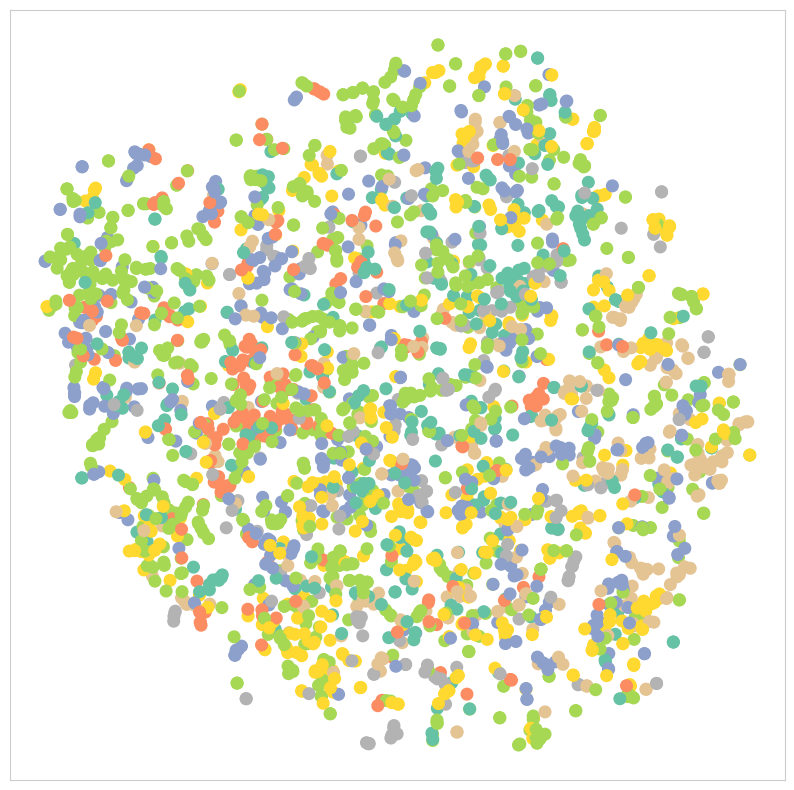

In [14]:
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [15]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9463
Epoch: 002, Loss: 1.9409
Epoch: 003, Loss: 1.9343
Epoch: 004, Loss: 1.9275
Epoch: 005, Loss: 1.9181
Epoch: 006, Loss: 1.9086
Epoch: 007, Loss: 1.9015
Epoch: 008, Loss: 1.8933
Epoch: 009, Loss: 1.8808
Epoch: 010, Loss: 1.8685
Epoch: 011, Loss: 1.8598
Epoch: 012, Loss: 1.8482
Epoch: 013, Loss: 1.8290
Epoch: 014, Loss: 1.8233
Epoch: 015, Loss: 1.8057
Epoch: 016, Loss: 1.7966
Epoch: 017, Loss: 1.7825
Epoch: 018, Loss: 1.7617
Epoch: 019, Loss: 1.7491
Epoch: 020, Loss: 1.7310
Epoch: 021, Loss: 1.7147
Epoch: 022, Loss: 1.7056
Epoch: 023, Loss: 1.6954
Epoch: 024, Loss: 1.6697
Epoch: 025, Loss: 1.6538
Epoch: 026, Loss: 1.6312
Epoch: 027, Loss: 1.6161
Epoch: 028, Loss: 1.5899
Epoch: 029, Loss: 1.5711
Epoch: 030, Loss: 1.5576
Epoch: 031, Loss: 1.5393
Epoch: 032, Loss: 1.5137
Epoch: 033, Loss: 1.4948
Epoch: 034, Loss: 1.4913
Epoch: 035, Loss: 1.4698
Epoch: 036, Loss: 1.3998
Epoch: 037, Loss: 1.4041
Epoch: 038, Loss: 1.3761
Epoch: 039, Loss: 1.3631
Epoch: 040, Loss: 1.3258


In [16]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8150


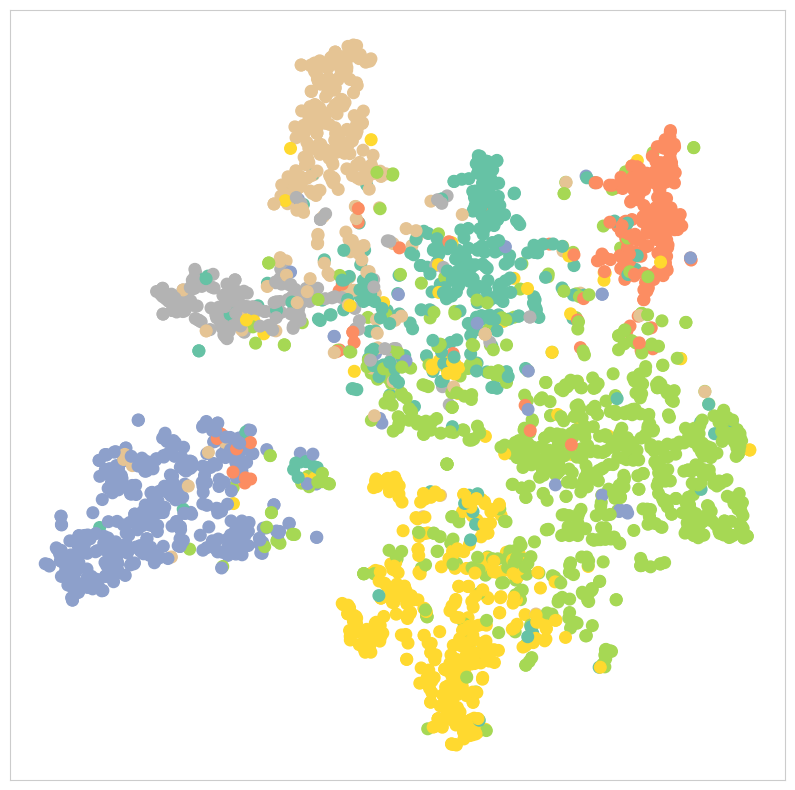

In [17]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

## GAT Training

In [18]:
from torch_geometric.nn import GATConv


class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        """ ***implement the GAT layers*** """
        self.conv1 = GATConv(dataset.num_features, hidden_channels) 
        self.conv2 = GATConv(hidden_channels, dataset.num_classes)  

    def forward(self, x, edge_index):
        """ ***complete the forward pass*** """
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x 

model = GAT(hidden_channels=8, heads=8)
print(model)

""" ***define the optimizer and criterion*** """
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
      acc = int(correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
      return acc

for epoch in range(1, 201):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

GAT(
  (conv1): GATConv(1433, 8, heads=1)
  (conv2): GATConv(8, 7, heads=1)
)
Epoch: 001, Loss: 1.9459, Val: 0.1820, Test: 0.2010
Epoch: 002, Loss: 1.9442, Val: 0.2840, Test: 0.2620
Epoch: 003, Loss: 1.9422, Val: 0.3720, Test: 0.3730
Epoch: 004, Loss: 1.9381, Val: 0.1900, Test: 0.2010
Epoch: 005, Loss: 1.9317, Val: 0.2380, Test: 0.2380
Epoch: 006, Loss: 1.9279, Val: 0.2960, Test: 0.2920
Epoch: 007, Loss: 1.9249, Val: 0.3660, Test: 0.3590
Epoch: 008, Loss: 1.9168, Val: 0.4060, Test: 0.4220
Epoch: 009, Loss: 1.9099, Val: 0.4240, Test: 0.4510
Epoch: 010, Loss: 1.9041, Val: 0.4700, Test: 0.5100
Epoch: 011, Loss: 1.8984, Val: 0.5540, Test: 0.5710
Epoch: 012, Loss: 1.8904, Val: 0.6380, Test: 0.6540
Epoch: 013, Loss: 1.8810, Val: 0.7040, Test: 0.7070
Epoch: 014, Loss: 1.8838, Val: 0.7300, Test: 0.7440
Epoch: 015, Loss: 1.8656, Val: 0.7320, Test: 0.7410
Epoch: 016, Loss: 1.8561, Val: 0.7280, Test: 0.7250
Epoch: 017, Loss: 1.8438, Val: 0.7280, Test: 0.7180
Epoch: 018, Loss: 1.8304, Val: 0.7260,

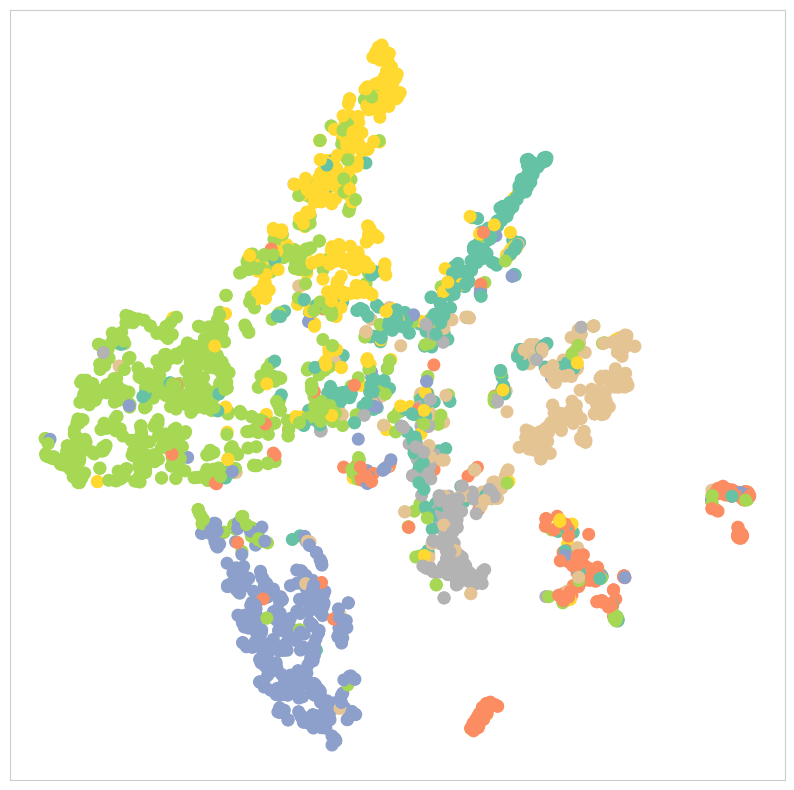

In [19]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)